In [1]:
%config InlineBackend.figure_formats = ['svg']

In [2]:
import numpy as np

import requests

import pandas as pd
import matplotlib.pyplot as plt

from matplotlib import dates as mdates

In [6]:
query = 'Denfert'
date = '2022-06-06'

In [7]:
new_records = True
all_records = []
start = 0
url = 'https://opendata.paris.fr/api/records/1.0/search/'
dataset = 'comptage-velo-donnees-compteurs'
while new_records:
    response = requests.get(f"{url}?dataset={dataset}&q={query}&refine.date={date}&start={start}")
    data = response.json()
    new_records = data['records']
    all_records += new_records
    start += data['parameters']['rows']

In [8]:
df = pd.json_normalize(all_records)
df.head()

,datasetid,recordid,record_timestamp,fields.sum_counts,fields.nom_compteur,fields.id_compteur,fields.coordinates,fields.type_dimage,fields.date,fields.installation_date,fields.name,fields.id,fields.counter,fields.url_photos_n1,fields.test_lien_vers_photos_du_site_de_comptage_,fields.photos,fields.url_sites,fields.id_photo_1,geometry.type,geometry.coordinates
0,comptage-velo-donnees-compteurs,e96d1e734b9fb67b0fa1d53bd713167d48b7ec35,2022-06-15T06:00:22.808Z,7.0,106 avenue Denfert Rochereau NE-SO 106 avenue ...,100003098-101003098,"[48.83521, 2.33307]",jpg,2022-06-06T05:00:00+00:00,2012-02-22,106 avenue Denfert Rochereau NE-SO,100003098,Y2H16029278,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://www.eco-visio.net/Photos/100003098,https:,Point,"[2.33307, 48.83521]"
1,comptage-velo-donnees-compteurs,df444bcd6d4cd1a7ca85d8836f32e160d9ab616e,2022-06-15T06:00:22.808Z,22.0,106 avenue Denfert Rochereau NE-SO 106 avenue ...,100003098-101003098,"[48.83521, 2.33307]",jpg,2022-06-06T06:00:00+00:00,2012-02-22,106 avenue Denfert Rochereau NE-SO,100003098,Y2H16029278,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://www.eco-visio.net/Photos/100003098,https:,Point,"[2.33307, 48.83521]"
2,comptage-velo-donnees-compteurs,987adc01c5ef410f7596d1d228e00ef6cf28c520,2022-06-15T06:00:22.808Z,38.0,106 avenue Denfert Rochereau NE-SO 106 avenue ...,100003098-101003098,"[48.83521, 2.33307]",jpg,2022-06-06T07:00:00+00:00,2012-02-22,106 avenue Denfert Rochereau NE-SO,100003098,Y2H16029278,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://www.eco-visio.net/Photos/100003098,https:,Point,"[2.33307, 48.83521]"
3,comptage-velo-donnees-compteurs,0812a4e2b4a84f4e218557da0cb84a722ccafc08,2022-06-15T06:00:22.808Z,31.0,106 avenue Denfert Rochereau NE-SO 106 avenue ...,100003098-101003098,"[48.83521, 2.33307]",jpg,2022-06-06T08:00:00+00:00,2012-02-22,106 avenue Denfert Rochereau NE-SO,100003098,Y2H16029278,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://www.eco-visio.net/Photos/100003098,https:,Point,"[2.33307, 48.83521]"
4,comptage-velo-donnees-compteurs,e52be6a2b57f8397c5b5053a58c6161559a99a19,2022-06-15T06:00:22.808Z,46.0,106 avenue Denfert Rochereau NE-SO 106 avenue ...,100003098-101003098,"[48.83521, 2.33307]",jpg,2022-06-06T10:00:00+00:00,2012-02-22,106 avenue Denfert Rochereau NE-SO,100003098,Y2H16029278,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://filer.eco-counter-tools.com/file/09/73...,https://www.eco-visio.net/Photos/100003098,https:,Point,"[2.33307, 48.83521]"


In [9]:
df = df[['fields.date', 'fields.sum_counts', 'fields.id_compteur', 'fields.nom_compteur']]
df['timestamp'] = pd.to_datetime(df['fields.date'])

In [10]:
max_flow = max(df_counter['fields.sum_counts'].sum() for _, df_counter in df.groupby('fields.id_compteur'))

In [11]:
counter_ids = df['fields.id_compteur'].unique()

In [12]:
dfs = {}
labels = {'100003098-101003098': 'N→S',
          '100003096-353242251': 'S→N'}
for counter_id, df_counter in df.groupby('fields.id_compteur'):
    df_interp = (
        df_counter.set_index('timestamp')['fields.sum_counts']
        .resample('1H', offset=0)
        .interpolate()
    )
    dfs[labels[counter_id]] = df_interp / df_interp.sum() * max_flow

In [13]:
df_interp_all = pd.DataFrame(dfs)
df_interp_all = df_interp_all.ewm(alpha=0.3).mean()

In [14]:
colors = [
    '#08F7FE',  # teal/cyan
    '#FE53BB',  # pink
    '#F5D300',  # yellow
    '#00ff41', # matrix green
]


In [15]:
plt.figure()

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

In [16]:
plt.style.use("seaborn-dark")

for param in ['figure.facecolor', 'axes.facecolor', 'savefig.facecolor']:
    plt.rcParams[param] = '#212946'  # bluish dark grey

for param in ['text.color', 'axes.labelcolor', 'xtick.color', 'ytick.color']:
    plt.rcParams[param] = '0.9'  # very light grey


Text(0.5, 0.98, 'flow of cyclist on av Denfert Rochereau')

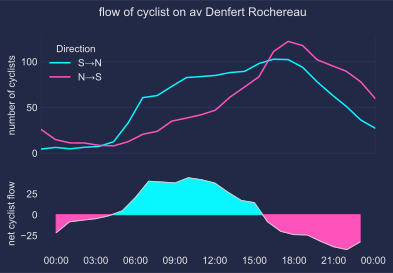

In [17]:
fig, axes = plt.subplots(nrows=2, gridspec_kw={"height_ratios": [3, 2]})

df_interp_all.plot(color=colors, ax=axes[0], sharex=True, legend=False)

axes[0].grid(color='#2A3459')
axes[0].legend(title='Direction')
axes[0].set_ylabel('number of cyclists')

df_flow = df_interp_all[['N→S', 'S→N']].diff(axis=1).dropna(axis=1)
y_flow = df_flow.values[:, 0]
axes[1].fill_between(df_flow.index, y_flow , where=y_flow >= 0, color=colors[0], interpolate=True)
axes[1].fill_between(df_flow.index, y_flow , where=y_flow < 0, color=colors[1], interpolate=True)
axes[1].plot(df_flow.index, y_flow, color='#CCCCCC', lw=1)

axes[1].xaxis.set_major_formatter(
    mdates.DateFormatter("%H:%M"),
    #mdates.ConciseDateFormatter(ax.xaxis.get_major_locator())
)
axes[1].set_ylabel('net cyclist flow')

fig.suptitle('flow of cyclist on av Denfert Rochereau')